In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr
from scipy.stats import norm, t
import matplotlib.pyplot as plt

# Import data

### Getting the stock data from yahoo and compute some parameters

In [2]:
def getData(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start=start, end=end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix

# Portfolio Performance
#### We compute here the Expected Portfolio Return and the standard deviation of the portfolio

In [3]:
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns*weights)*Time
    std = np.sqrt( np.dot(weights.T, np.dot(covMatrix, weights)) ) * np.sqrt(Time)
    return returns, std

### Compute returns data

In [4]:
stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stocks = [stock+'.AX' for stock in stockList]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=800)
returns, meanReturns, covMatrix = getData(stocks, start=startDate, end=endDate)
returns = returns.dropna()

In [5]:
returns

Symbols,CBA.AX,BHP.AX,TLS.AX,NAB.AX,WBC.AX,STO.AX
Date,,,,,,
2020-07-28,-0.003863,0.017380,0.002976,-0.002786,-0.014673,-0.019928
2020-07-29,0.011079,-0.019711,-0.002967,0.015642,0.013746,-0.014787
2020-07-30,0.002876,0.014209,0.005952,-0.003300,-0.001695,0.018762
2020-07-31,-0.027588,-0.028549,-0.008876,-0.025386,-0.032824,-0.029466
2020-08-03,-0.017837,0.016054,0.014925,-0.040770,-0.035108,0.007590
...,...,...,...,...,...,...
2022-09-26,-0.000320,-0.051611,-0.002653,0.000000,-0.011204,-0.072776
2022-09-27,-0.001923,0.027624,-0.010638,-0.003407,-0.005666,0.010174
2022-09-28,-0.009526,0.001344,0.026882,-0.008889,-0.006173,-0.012950


<AxesSubplot:>

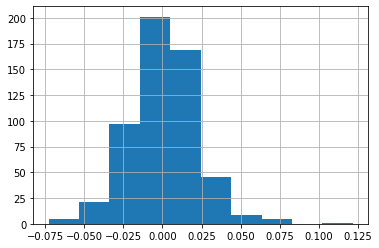

In [6]:
returns['STO.AX'].hist()

### Compute random weight for each asset that will helps us compute the portfolio

In [7]:
weights = np.random.random(len(returns.columns))
weights /= np.sum(weights)
returns['portfolio'] = returns.dot(weights)

In [8]:
returns

Symbols,CBA.AX,BHP.AX,TLS.AX,NAB.AX,WBC.AX,STO.AX,portfolio
Date,,,,,,,
2020-07-28,-0.003863,0.017380,0.002976,-0.002786,-0.014673,-0.019928,-0.004426
2020-07-29,0.011079,-0.019711,-0.002967,0.015642,0.013746,-0.014787,-0.000621
2020-07-30,0.002876,0.014209,0.005952,-0.003300,-0.001695,0.018762,0.007125
2020-07-31,-0.027588,-0.028549,-0.008876,-0.025386,-0.032824,-0.029466,-0.025522
2020-08-03,-0.017837,0.016054,0.014925,-0.040770,-0.035108,0.007590,-0.006990
...,...,...,...,...,...,...,...
2022-09-26,-0.000320,-0.051611,-0.002653,0.000000,-0.011204,-0.072776,-0.025766
2022-09-27,-0.001923,0.027624,-0.010638,-0.003407,-0.005666,0.010174,0.002994
2022-09-28,-0.009526,0.001344,0.026882,-0.008889,-0.006173,-0.012950,-0.001889


<AxesSubplot:>

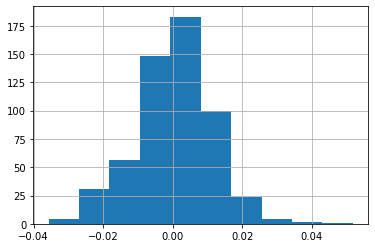

In [9]:
returns['portfolio'].hist()

### Compute historical_Var on one asset or for the entire portfolio

In [10]:
def VaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the percentile of the distribution at the given alpha confidence level
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(VaR, alpha=alpha)
    else:
        raise TypeError("Expected returns to be dataframe or series")

In [11]:
VaR(returns, alpha=5)

Symbols
CBA.AX      -0.020749
BHP.AX      -0.031117
TLS.AX      -0.017593
NAB.AX      -0.020781
WBC.AX      -0.020995
STO.AX      -0.032896
portfolio   -0.019691
dtype: float64

In [12]:
VaR(returns['portfolio'], alpha=5)

-0.019690718621035774

### Compute historical_CVar on one asset or for the entire portfolio

In [13]:
def CVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the CVaR for dataframe / series
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= VaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(CVaR, alpha=alpha)
    else:
        raise TypeError("Expected returns to be dataframe or series")

In [14]:
CVaR(returns, alpha=5)

Symbols
CBA.AX      -0.030004
BHP.AX      -0.047766
TLS.AX      -0.025651
NAB.AX      -0.028399
WBC.AX      -0.030362
STO.AX      -0.045332
portfolio   -0.024245
dtype: float64

### We Apply now our var and cvar models to an itinial investement = 10000
#### What we want to know is given the level of risk alpha= 5 what is the worst case scenario and the expectation of loss in this worst case scenario

In [15]:
# 10 days
Time = 10
hVaR = -VaR(returns['portfolio'], alpha=5)*np.sqrt(Time)
hCVaR = -CVaR(returns['portfolio'], alpha=5)*np.sqrt(Time)
pRet, pStd = portfolioPerformance(weights, meanReturns, covMatrix, Time)
InitialInvestment = 10000
print('Expected Portfolio Return:      ', round(InitialInvestment*pRet,2))
print('Value at Risk 95th CI    :      ', round(InitialInvestment*hVaR,2))
print('Conditional VaR 95th CI  :      ', round(InitialInvestment*hCVaR,2))

Expected Portfolio Return:       50.48
Value at Risk 95th CI    :       622.68
Conditional VaR 95th CI  :       766.7


#### Explanation: 
##### Over a 10 days time horizon, we expect to make 6.04 and at the 95% interval confidence we are happy to not lose anymore thant 249.04

In [16]:

def var_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    # because the distribution is symmetric
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR

In [17]:
def cvar_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR

In [18]:
normVaR = var_parametric(pRet, pStd)
normCVaR = cvar_parametric(pRet, pStd)
tVaR = var_parametric(pRet, pStd, distribution='t-distribution')
tCVaR = cvar_parametric(pRet, pStd, distribution='t-distribution')

In [19]:
print("Normal VaR 95th CI       :      ", round(InitialInvestment*normVaR,2))
print("Normal CVaR 95th CI      :      ", round(InitialInvestment*normCVaR,2))
print("t-dist VaR 95th CI       :      ", round(InitialInvestment*tVaR,2))
print("t-dist CVaR 95th CI      :      ", round(InitialInvestment*tCVaR,2))

Normal VaR 95th CI       :       531.83
Normal CVaR 95th CI      :       679.76
t-dist VaR 95th CI       :       511.21
t-dist CVaR 95th CI      :       712.85
